<a href="https://colab.research.google.com/github/arya-t-a/AI-academic-project/blob/main/Fine_grained_Indian_food_image_recognition_using_PRENet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Found 3118 files belonging to 13 classes.
Using 2495 files for training.
Found 3118 files belonging to 13 classes.
Using 623 files for validation.
['Biryani', 'Butter_Naan', 'Chai', 'Chole_Bhature', 'Dhokla', 'Egg_biriyani', 'Gulab_Jamun', 'Jalebi', 'Momos', 'Paneer_Sabzi', 'Pav_Bhaji', 'Rasgulla', 'Samosa']
94765736/94765736 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 resnet50 (Funct

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


78/78 [==============================] - 660s 8s/step - loss: 3.7885 - stage_1_output_loss: 1.5254 - stage_2_output_loss: 1.1934 - stage_3_output_loss: 1.2970 - final_output_loss: 2.4499 - stage_1_output_accuracy: 0.5267 - stage_2_output_accuracy: 0.6144 - stage_3_output_accuracy: 0.5984 - final_output_accuracy: 0.2453 - val_loss: 3.1302 - val_stage_1_output_loss: 0.8214 - val_stage_2_output_loss: 0.7642 - val_stage_3_output_loss: 0.8760 - val_final_output_loss: 2.3096 - val_stage_1_output_accuracy: 0.7464 - val_stage_2_output_accuracy: 0.7448 - val_stage_3_output_accuracy: 0.7271 - val_final_output_accuracy: 0.3708
Epoch 2/50
78/78 [==============================] - 568s 7s/step - loss: 3.1269 - stage_1_output_loss: 1.0337 - stage_2_output_loss: 0.8188 - stage_3_output_loss: 0.8876 - final_output_loss: 2.2135 - stage_1_output_accuracy: 0.7018 - stage_2_output_accuracy: 0.7535 - stage_3_output_accuracy: 0.7443 - final_output_accuracy: 0.4192 - val_loss: 2.9722 - val_stage_1_output_loss

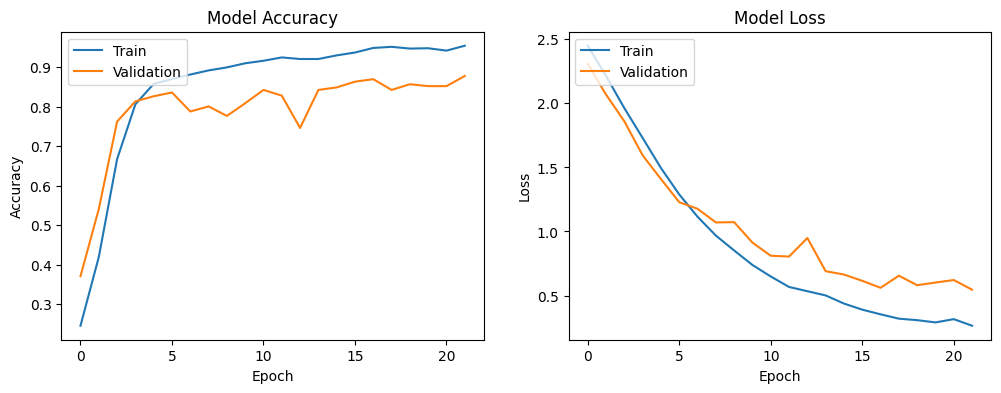

1/1 [==============================] - 2s 2s/step
The predicted class is Biryani
The predicted class for the outside image is Biryani
1/1 [==============================] - 3s 3s/step


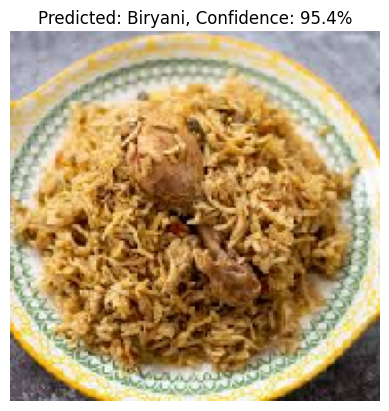

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pathlib
import cv2

# Setting up dataset paths
data_dir = '/content/drive/MyDrive/own_db2/train'
data_dir = pathlib.Path(data_dir)

# Defining image parameters and batch size
img_height, img_width = 180, 180
batch_size = 32

# Loading the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

class_names = train_ds.class_names
print(class_names)

# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Self-Attention Layer
class SelfAttention(layers.Layer):
    def __init__(self, num_heads, key_dim):
        super(SelfAttention, self).__init__()
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self.layernorm = layers.LayerNormalization(epsilon=1e-6)
        self.add = layers.Add()

    def call(self, inputs):
        attention_output = self.mha(inputs, inputs)
        x = self.add([inputs, attention_output])
        x = self.layernorm(x)
        return x

# Progressive Model Creation
def create_progressive_model(num_stages, num_classes):
    inputs = layers.Input(shape=(img_height, img_width, 3))
    x = data_augmentation(inputs)

    stage_outputs = []
    for i in range(num_stages):
        if i == 0:
            resnet_base = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',
                                                         input_shape=(img_height, img_width, 3))
            for layer in resnet_base.layers:
                layer.trainable = False
            x = resnet_base(x)
        else:
            # Custom layers for subsequent stages
            x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
            x = layers.BatchNormalization()(x)
            x = layers.MaxPooling2D()(x)

        x = SelfAttention(num_heads=8, key_dim=64)(x)

        # Global average pooling and dense layers for each stage output
        stage_output = layers.GlobalAveragePooling2D()(x)
        stage_output = layers.Dense(512, activation='relu')(stage_output)
        stage_output = layers.Dropout(0.5)(stage_output)
        stage_output = layers.Dense(num_classes, activation='softmax', name=f'stage_{i+1}_output')(stage_output)
        stage_outputs.append(stage_output)

    # Final output
    concat_features = layers.Concatenate()(stage_outputs)
    final_output = layers.Dense(num_classes, activation='softmax', name='final_output')(concat_features)

    return tf.keras.Model(inputs=inputs, outputs=[*stage_outputs, final_output])

# Create the model
num_stages = 3
final_model = create_progressive_model(num_stages, len(class_names))
final_model.summary()

# Loss functions
def kl_divergence_loss(y_true, y_pred):
    kl_loss = tf.keras.losses.KLDivergence()(y_true, y_pred)
    return kl_loss

def combined_loss(y_true, y_pred):
    ce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    kl_loss = sum([kl_divergence_loss(y_true, final_model.outputs[i])
                   for i in range(num_stages)])
    return ce_loss + 0.1 * kl_loss

# Compile the model
final_model.compile(optimizer=Adam(learning_rate=0.001),
                    loss=[*['categorical_crossentropy']*num_stages, 'categorical_crossentropy'],
                    loss_weights=[*[1/num_stages]*num_stages, 1],
                    metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

# Training the model
epochs = 50
history = final_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint]
)

# Plotting accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['final_output_accuracy'])
plt.plot(history.history['val_final_output_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['final_output_loss'])
plt.plot(history.history['val_final_output_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Function to predict an image
def predict_image(image_path):
    image = cv2.imread(image_path)
    image_resized = cv2.resize(image, (img_height, img_width))
    image = np.expand_dims(image_resized, axis=0)

    predictions = final_model.predict(image)
    stage_predictions = predictions[:-1]
    final_prediction = predictions[-1]

    combined_prediction = np.mean([*stage_predictions, final_prediction], axis=0)
    output_class = class_names[np.argmax(combined_prediction)]

    print("The predicted class is", output_class)
    return output_class

# Example usage of the predict_image function
outside_image_path = '/content/tr4.jpg'  # Change this to the path of your image
predicted_class = predict_image(outside_image_path)
print(f'The predicted class for the outside image is {predicted_class}')

def show_prediction(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = final_model.predict(img_array)
    combined_prediction = np.mean([*predictions[:-1], predictions[-1]], axis=0)
    predicted_class = class_names[np.argmax(combined_prediction)]
    confidence = round(100 * np.max(combined_prediction), 2)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence}%")
    plt.show()

show_prediction(outside_image_path)

# Save the model
final_model.save('best_progressive_model.h5')



Found 540 files belonging to 13 classes.
Classes: ['Biryani', 'Butter Naan', 'Chai', 'Chole Bhature', 'Dhokla', 'Egg_biriyani', 'Gulab Jamun', 'Jalebi', 'Momos', 'Paneer Sabzi', 'Pav Bhaji', 'Rasgulla', 'Samosa']
Evaluating the model on test data...
17/17 [==============================] - 121s 5s/step - loss: 1.5559 - stage_1_output_loss: 1.0106 - stage_2_output_loss: 0.8095 - stage_3_output_loss: 0.8073 - final_output_loss: 0.6801 - stage_1_output_accuracy: 0.8444 - stage_2_output_accuracy: 0.8370 - stage_3_output_accuracy: 0.8370 - final_output_accuracy: 0.8426
Test Loss: 1.5558830499649048
Test Accuracy: 0.8425925970077515
1/1 [==============================] - 2s 2s/step


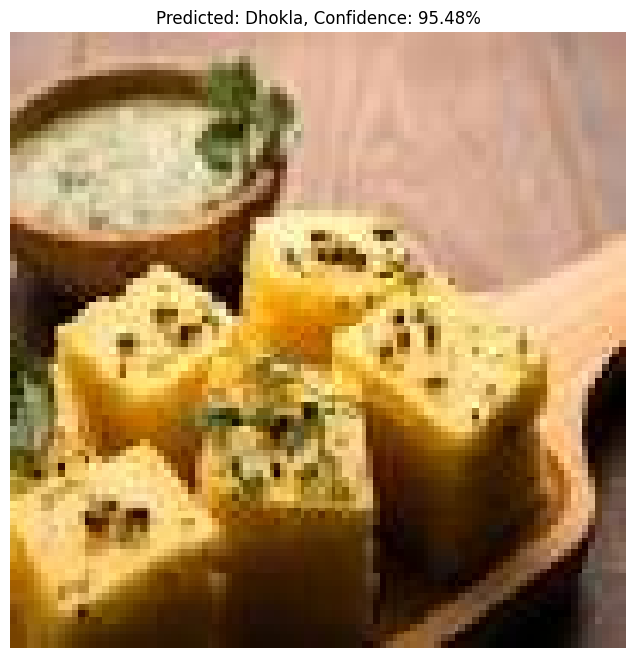

Predicted class: Dhokla
Confidence: 95.48%
1/1 [==============================] - 0s 155ms/step


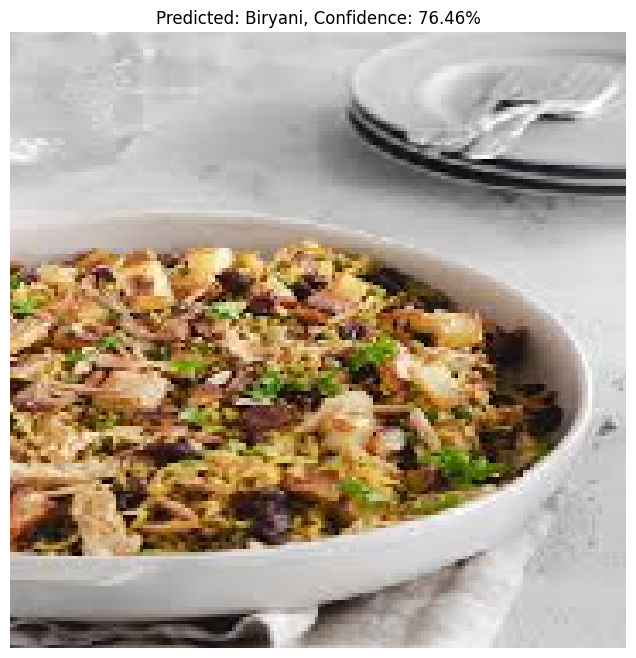

Predicted class: Biryani
Confidence: 76.46%
1/1 [==============================] - 0s 167ms/step


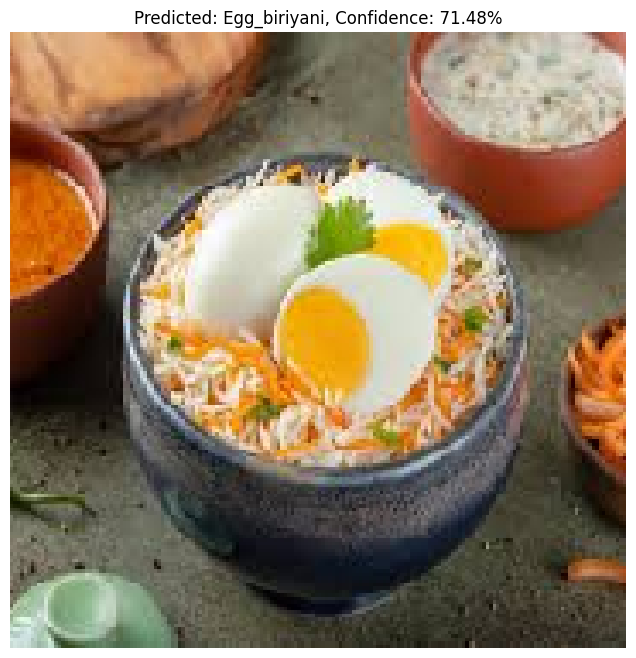

Predicted class: Egg_biriyani
Confidence: 71.48%
Generating confusion matrix...
1/1 [==============================] - 3s 3s/step


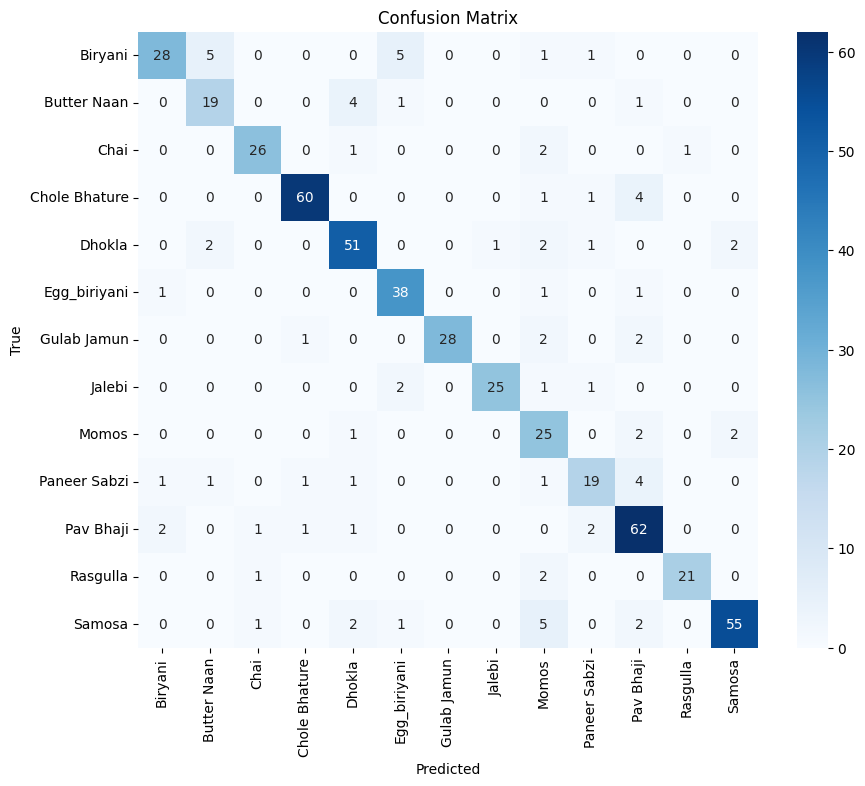

Classification Report:
               precision    recall  f1-score   support

      Biryani       0.88      0.70      0.78        40
  Butter Naan       0.70      0.76      0.73        25
         Chai       0.90      0.87      0.88        30
Chole Bhature       0.95      0.91      0.93        66
       Dhokla       0.84      0.86      0.85        59
 Egg_biriyani       0.81      0.93      0.86        41
  Gulab Jamun       1.00      0.85      0.92        33
       Jalebi       0.96      0.86      0.91        29
        Momos       0.58      0.83      0.68        30
 Paneer Sabzi       0.76      0.68      0.72        28
    Pav Bhaji       0.79      0.90      0.84        69
     Rasgulla       0.95      0.88      0.91        24
       Samosa       0.93      0.83      0.88        66

     accuracy                           0.85       540
    macro avg       0.85      0.84      0.84       540
 weighted avg       0.86      0.85      0.85       540



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import pathlib
import cv2

# Load the saved model
model = load_model('best_progressive_model.h5', custom_objects={'SelfAttention': SelfAttention})

# Setting up test dataset path
test_data_dir = '/content/drive/MyDrive/test1'  # Replace with your test data directory
test_data_dir = pathlib.Path(test_data_dir)

# Image parameters
img_height, img_width = 180, 180
batch_size = 32

# Load test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    label_mode="categorical",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Get class names
class_names = test_ds.class_names
print("Classes:", class_names)

# Evaluate the model
print("Evaluating the model on test data...")
test_results = model.evaluate(test_ds, verbose=1)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[-1])

# Function to predict and visualize a single image
def predict_and_visualize(image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    combined_prediction = np.mean([*predictions[:-1], predictions[-1]], axis=0)
    predicted_class = class_names[np.argmax(combined_prediction)]
    confidence = round(100 * np.max(combined_prediction), 2)

    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {predicted_class}, Confidence: {confidence}%")
    plt.show()

    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence}%")

# Test the model on a few individual images
test_image_paths = [
    '/content/drive/MyDrive/test/Dhokla/image_1.jpg',
    '/content/drive/MyDrive/test1/Biryani/image_27.jpg',
    '/content/drive/MyDrive/test1/Egg_biriyani/36.jpg'
]

for image_path in test_image_paths:
    predict_and_visualize(image_path)

# Generate confusion matrix
print("Generating confusion matrix...")
y_pred = []
y_true = []

for image_batch, label_batch in test_ds:
    predictions = model.predict(image_batch)
    combined_prediction = np.mean([*predictions[:-1], predictions[-1]], axis=0)
    y_pred.extend(np.argmax(combined_prediction, axis=1))
    y_true.extend(np.argmax(label_batch, axis=1))

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))